In [8]:
import pandas as pd




In [9]:
# Load the dataset
file_path = '/content/bank_transactions.csv'  # Path to the uploaded dataset
df = pd.read_csv(file_path)



In [10]:
# Display the first few rows of the dataset
print(df.head())

  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2            T3   C4417068    26/11/96          F       MUMBAI   
3            T4   C5342380     14/9/73          F       MUMBAI   
4            T5   C9031234     24/3/88          F  NAVI MUMBAI   

   CustAccountBalance TransactionDate  TransactionTime  \
0            17819.05          2/8/16           143207   
1             2270.69          2/8/16           141858   
2            17874.44          2/8/16           142712   
3           866503.21          2/8/16           142714   
4             6714.43          2/8/16           181156   

   TransactionAmount (INR)  
0                     25.0  
1                  27999.0  
2                    459.0  
3                   2060.0  
4                   1762.5  


In [11]:
# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        4.883220e+05    489641.000000             4.896410e+05
mean         1.115325e+05    156518.399482             1.607372e+03
std          7.137746e+05     51039.875125             6.631565e+03
min          0.000000e+00         0.000000             0.000000e+00
25%          4.584950e+03    124205.000000             1.740000e+02
50%          1.655755e+04    163135.000000             4.860000e+02
75%          5.689737e+04    195658.000000             1.244000e+03
max          1.150355e+08    235959.000000             1.560035e+06
TransactionID                 0
CustomerID                    0
CustomerDOB                1550
CustGender                  517
CustLocation                 86
CustAccountBalance         1319
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64


In [12]:
# Drop rows with missing values
df.dropna(inplace=True)

# Remove duplicates if any
df.drop_duplicates(inplace=True)

# Display the cleaned data
print(df.head())


  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2            T3   C4417068    26/11/96          F       MUMBAI   
3            T4   C5342380     14/9/73          F       MUMBAI   
4            T5   C9031234     24/3/88          F  NAVI MUMBAI   

   CustAccountBalance TransactionDate  TransactionTime  \
0            17819.05          2/8/16           143207   
1             2270.69          2/8/16           141858   
2            17874.44          2/8/16           142712   
3           866503.21          2/8/16           142714   
4             6714.43          2/8/16           181156   

   TransactionAmount (INR)  
0                     25.0  
1                  27999.0  
2                    459.0  
3                   2060.0  
4                   1762.5  


In [14]:
# Convert TransactionDate to datetime format if necessary
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Calculate total amount spent by each customer
customer_df = df.groupby('CustomerID').agg({
    'TransactionAmount (INR)': 'sum',    # Total amount spent
    'TransactionDate': 'count'     # Number of transactions
}).rename(columns={'TransactionDate': 'TransactionCount'})

# Display the first few rows of the aggregated data
print(customer_df.head())


            TransactionAmount (INR)  TransactionCount
CustomerID                                           
C1010011                     5106.0                 2
C1010012                     1499.0                 1
C1010014                     1455.0                 2
C1010024                     5000.0                 1
C1010031                     1864.0                 2


In [15]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
customer_df_normalized = scaler.fit_transform(customer_df)

# Convert back to a DataFrame for ease of use
customer_df_normalized = pd.DataFrame(customer_df_normalized, columns=customer_df.columns, index=customer_df.index)


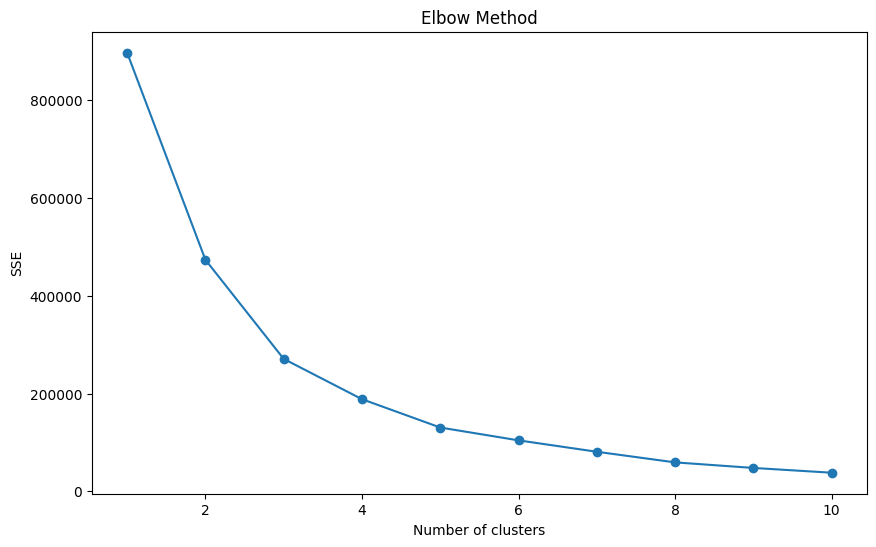

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_df_normalized)
    sse.append(kmeans.inertia_)

# Plot the SSE for each value of k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# Choose the optimal number of clusters (e.g., 3) and fit the KMeans model
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans.fit_predict(customer_df_normalized)


In [22]:
import seaborn as sns

# Analyze the characteristics of each cluster
cluster_summary = customer_df.groupby('Cluster').agg({
    'TransactionCount': 'mean',
    'TransactionAmount (INR)': 'mean'
}).reset_index()

print(cluster_summary)

   Cluster  TransactionCount  TransactionAmount (INR)
0        0          1.000000              1312.496148
1        1          2.066865              2722.115410
2        2          1.140369             72775.626803


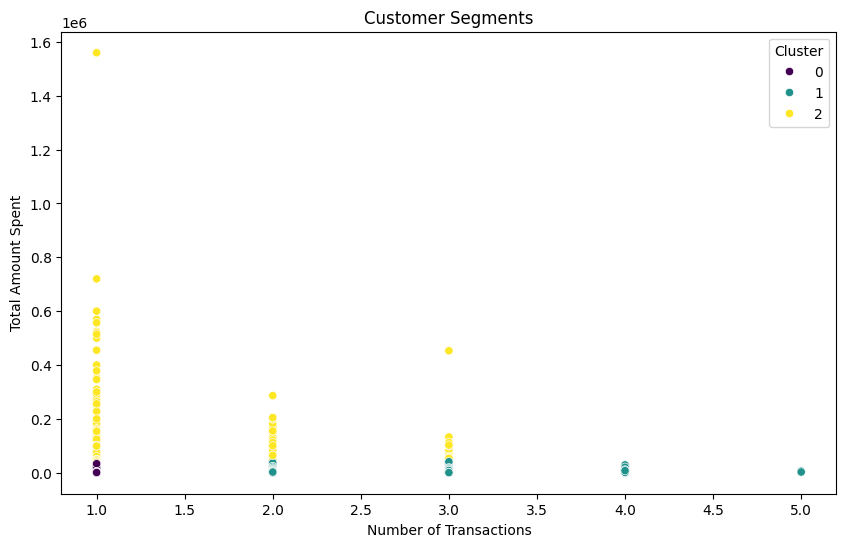

In [21]:
# Visualize the segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TransactionCount', y='TransactionAmount (INR)', hue='Cluster', data=customer_df, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Amount Spent')
plt.show()

In [23]:
customer_df.to_csv('customer_segments.csv', index=False)


In [24]:
# Profile each segment
for cluster in customer_df['Cluster'].unique():
    print(f"Cluster {cluster} Profile:")
    print(customer_df[customer_df['Cluster'] == cluster].describe())
    print("\n")


Cluster 1 Profile:
       TransactionAmount (INR)  TransactionCount  Cluster
count             35250.000000      35250.000000  35250.0
mean               2722.115410          2.066865      1.0
std                4251.972325          0.261771      0.0
min                   2.000000          2.000000      1.0
25%                 640.000000          2.000000      1.0
50%                1375.000000          2.000000      1.0
75%                2928.750000          2.000000      1.0
max               45294.000000          5.000000      1.0


Cluster 0 Profile:
       TransactionAmount (INR)  TransactionCount   Cluster
count            411114.000000          411114.0  411114.0
mean               1312.496148               1.0       0.0
std                2913.293003               0.0       0.0
min                   0.000000               1.0       0.0
25%                 171.000000               1.0       0.0
50%                 480.000000               1.0       0.0
75%                1211.0